# Part 5: Convexity and Constrained Optimization

In [8]:
import importlib

import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import useful_functions
importlib.reload(useful_functions)
from useful_functions import generate_dataset, unison_shuffled_copies, get_train_test_datasets, gradient_descent
from useful_functions import plot_convergence_rate, plot_evolution_on_test_error, plot_evolution_on_test_error_with_bias


### Question 1: Add an l2 regularization term to your objective function from Part 1 or Part 3. Compare the solution of the unregularized problem to those obtained while solving the problem with a) a small value for the regularization parameter and b) a large value for the regularization parameter

In [9]:
#% of rows to include in training dataset
TRAINING_RATIO = 0.75

In [3]:
dataset = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=False)
A = dataset['data']
Y = dataset['target']
A_shuffled, Y_shuffled = unison_shuffled_copies(A, Y)
A_train, Y_train, A_test, Y_test = get_train_test_datasets(A_shuffled, Y_shuffled,TRAINING_RATIO)

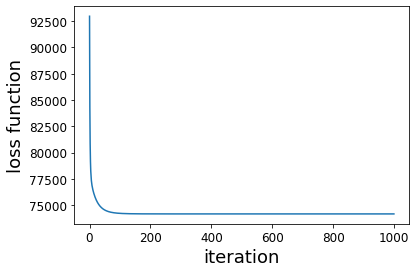

In [12]:
nb_of_iterations = 1000
step_size = 1e-5
ridge_parameter = 0

iteration, loss_function_array = gradient_descent(A_train, Y_train, nb_of_iterations, step_size, ridge_parameter, add_bias = False)
plt.plot(iteration, loss_function_array)   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()

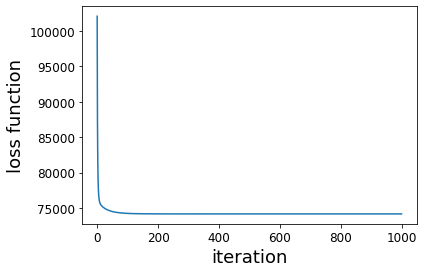

In [11]:
nb_of_iterations = 1000
step_size = 1e-5
ridge_parameter = 0.2

iteration, loss_function_array = gradient_descent(A_train, Y_train, nb_of_iterations, step_size, ridge_parameter, add_bias = False)
plt.plot(iteration, loss_function_array)   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()


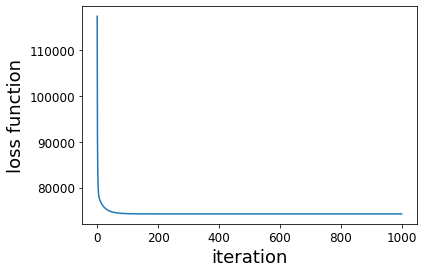

In [10]:
nb_of_iterations = 1000
step_size = 1e-5
ridge_parameter = 50

iteration, loss_function_array = gradient_descent(A_train, Y_train, nb_of_iterations, step_size, ridge_parameter, add_bias = False)
plt.plot(iteration, loss_function_array)   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()

Ridge: 1.70318759721485
Optimal X is :
[ 0.03723891  0.00592218  0.00817616 -0.00306841 -0.00130585 -0.00149642
 -0.00787803 -0.00271699]


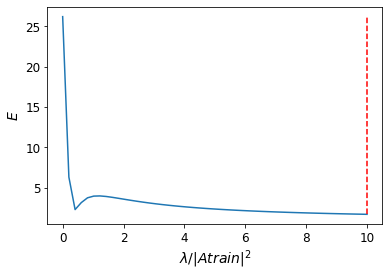

In [7]:
start = 1e-3
stop = 10
num = 50
plot_evolution_on_test_error(A_train, Y_train, A_test, Y_test, start, stop, num)

### Question 2 : Add a l-1 regularization term to your objective function from Part 1 or Part 3 and solve the resulting problem. Can you find a value of the regularization parameter that yields a sparse solution? Does it provide a good value for the data-fitting term?

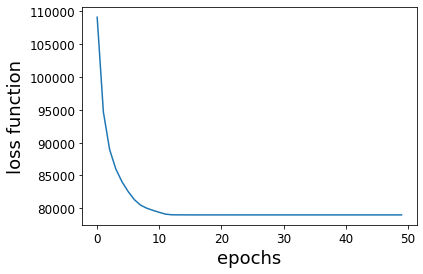

Optimal parameter is:
[ 0.70799865  0.11092323  0.          0.          0.          0.
 -0.01320565  0.        ]


In [46]:
#GD implementation with lasso 
n_epochs = 50
step_size = 1e-5
lasso_parameter = 3000
D = A_train.shape[1] # dimension of pbm 

x = np.random.rand(D) # random initialization

loss_function_array_lasso = []
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2 + lasso_parameter*np.linalg.norm(x, ord=1)
    loss_function_array_lasso.append(loss_function_train)
    gradients = 2*A_train.T.dot(np.dot(A_train,x)-Y_train) #gradient of the smooth part 

    #ista 
    threshold = step_size*lasso_parameter
    for i in range(D): #component wise
            vali = x[i]-step_size*gradients[i]
            if vali < -threshold:
                x[i] = vali+threshold
            elif vali > threshold:
                x[i] = vali-threshold
            else:
                x[i] = 0

plt.plot(epochs, loss_function_array_lasso)   
plt.xlabel("epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()
print("Optimal parameter is:")
print(x)

For a lambda of 1000 we are able to have a sparse solution, not so optimal though for data-fitting (underfitting).

Lasso: 36.54963976828266%


Text(0, 0.5, '$E$')

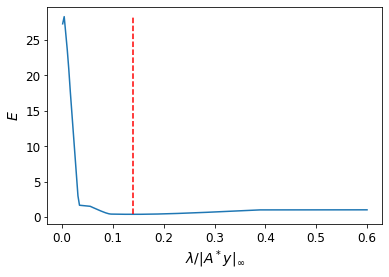

In [44]:
#Code from Gabriel Peyré

q = 200
lmax = np.linalg.norm(A_train,2)**2
lambda_list = lmax*np.linspace(.6,1e-3,q)
niter = 500
step_size = 1e-5

#Soft threholding operator
def Soft(x,s): return np.maximum( abs(x)-s, np.zeros(len(x))  ) * np.sign(x)

#ISTA 
C = A_train.transpose().dot(A_train)
u = A_train.transpose().dot(Y_train)
def ISTA(x,lasso_parameter,step_size): return Soft( x-step_size*( C.dot(x)-u ), lasso_parameter*step_size )


X = np.zeros( (D,q) )
E = np.zeros( (q,1) )
x = np.zeros(D)

for iq in np.arange(0,q):
    Lambda = lambda_list[iq]
    # ISTA #
    for i in np.arange(0,niter):
        x = ISTA(x,Lambda,step_size)
    X[:,iq] = x.flatten() # bookkeeping
    E[iq] = np.linalg.norm(A_test.dot(x)-Y_test) / np.linalg.norm(Y_test)

# find optimal Lambda
i = E.argmin()
lambda0 = lambda_list[i]
xSparse = X[:,i]
print( 'Lasso: ' + str(E.min()*100) + '%' )
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(),E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|A^* y|_\infty$')
plt.ylabel('$E$')